# Task
Develop a Spark-based solution in Google Colab using Python to predict EV charging station load for a Big Data project.

## Set up spark in colab

### Subtask:
Install and configure PySpark in the Google Colab environment.


**Reasoning**:
Install pyspark and findspark and initialize spark to prepare the environment for the next steps.



In [ ]:
!pip install pyspark findspark
import findspark
findspark.init()
import pyspark
print(pyspark.__version__)

3.5.1


## Load and explore the data

### Subtask:
Load the EV charging station data into a Spark DataFrame and perform initial data exploration to understand its structure and content.


**Reasoning**:
Initialize a SparkSession and load the data into a Spark DataFrame, then display the schema, show the first few rows, and count the number of rows to perform initial data exploration.



**Reasoning**:
The previous attempt to load the data failed because the file path was incorrect. I need to check the available files to find the correct file path and then attempt to load the data again, followed by displaying the schema, showing the first few rows, and counting the number of rows.



## Data preprocessing

### Subtask:
Clean and preprocess the data, handling missing values, outliers, and transforming features as needed for the prediction model. This might include feature engineering to create relevant features for load prediction (e.g., time-based features, location-based features).


**Reasoning**:
Check for missing values in the spark_df DataFrame.



**Reasoning**:
Based on the missing value analysis, there are no missing values in the DataFrame, so no handling is required. The next step is to identify potential outliers using descriptive statistics.



**Reasoning**:
The descriptive statistics show potential outliers in columns like `total_rooms`, `total_bedrooms`, `population`, and `households` given the large difference between the max and mean values. A common strategy for handling outliers in these types of features is capping the values at a certain percentile (e.g., 99th percentile) to reduce their influence without removing data points entirely. This is a reasonable approach for these features which represent counts and can have skewed distributions. Since there are no missing values and no categorical features, scaling numerical features is the final step of the preprocessing.



## Feature selection and engineering

### Subtask:
Select the most relevant features for the prediction model and potentially engineer new features from existing ones to improve model performance.


## Model selection

### Subtask:
Choose an appropriate model for time series load prediction.


**Reasoning**:
Based on the subtask, I need to select an appropriate Spark MLlib regression model. Gradient Boosted Trees Regression is a good choice for potentially non-linear relationships in the data and often provides good performance in regression tasks. I will import the necessary class from `pyspark.ml.regression`.



## Train the model

### Subtask:
Split the data into training and testing sets and train the selected model using the training data in Spark.


**Reasoning**:
Split the data into training and testing sets, instantiate and train the GBTRegressor model as instructed.



**Reasoning**:
Evaluate the performance of the trained GBTRegressor model on the testing data using RMSE.



## Visualize results

### Subtask:
Visualize the predicted load and compare it with actual load data (if available) to assess the model's accuracy.


**Reasoning**:
Convert the Spark DataFrame 'predictions' to a Pandas DataFrame to prepare for visualization, and then create a scatter plot comparing the actual and predicted load, adding a diagonal line for reference and appropriate labels and title.



In [2]:
!pip install pyspark findspark
import findspark
findspark.init()
import pyspark
print(f"PySpark version: {pyspark.__version__}")


PySpark version: 3.5.1


In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta


In [4]:
spark = SparkSession.builder \
    .appName("EVChargingLoadPrediction") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

print("Spark Session Created Successfully")
print(f"Spark Version: {spark.version}")


Spark Session Created Successfully
Spark Version: 3.5.1


In [ ]:
# ============================================================
# EV Charging Station Load Data Generator
# Works with Python & PySpark environments
# ============================================================

import builtins  # ensures built-in max() is used, not Spark's
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# ----------------------------
# Configuration
# ----------------------------
np.random.seed(42)
n_records = 5000000
minimum_load = 5  # minimum safe charging load in kW

# ----------------------------
# Create datetime range
# ----------------------------
start_date = datetime(2023, 1, 1)
dates = [start_date + timedelta(hours=i) for i in range(n_records)]

# ----------------------------
# Generate input features
# ----------------------------
data = {
    'timestamp': dates,
    'hour_of_day': [d.hour for d in dates],
    'day_of_week': [d.weekday() for d in dates],
    'month': [d.month for d in dates],
    'temperature': np.random.normal(20, 8, n_records),  # average 20°C ± 8
    'num_available_chargers': np.random.randint(5, 20, n_records),
    'is_weekend': [1 if d.weekday() >= 5 else 0 for d in dates],
    'is_holiday': np.random.choice([0, 1], n_records, p=[0.95, 0.05]),
    'electricity_price': np.random.uniform(0.1, 0.4, n_records),
}

# ----------------------------
# Generate realistic charging load
# ----------------------------
base_load = []
for i in range(n_records):
    hour = data['hour_of_day'][i]
    is_weekend = data['is_weekend'][i]

    # Charging patterns based on time and weekday/weekend
    if not is_weekend and ((7 <= hour <= 9) or (17 <= hour <= 20)):
        # Morning & evening rush (peak)
        base = np.random.uniform(80, 150)
    elif 10 <= hour <= 16:
        # Midday (moderate)
        base = np.random.uniform(40, 80)
    elif hour >= 22 or hour <= 6:
        # Night (low usage)
        base = np.random.uniform(10, 30)
    elif is_weekend:
        # Weekend moderate traffic
        base = np.random.uniform(30, 70)
    else:
        base = np.random.uniform(20, 60)

    # Adjust load based on temperature (higher temp = slightly higher cooling needs)
    load = base + np.random.normal(0, 10) + (data['temperature'][i] - 20) * 0.5

    # Ensure minimum load threshold
    load = builtins.max(minimum_load, load)

    base_load.append(load)

data['charging_load_kW'] = base_load

# ----------------------------
# Convert to DataFrame and save
# ----------------------------
df_pandas = pd.DataFrame(data)
output_path = '/content/EV_Charging_Station_Load.csv'
df_pandas.to_csv(output_path, index=False)

# ----------------------------
# Display summary
# ----------------------------
print("✅ Dataset created successfully!")
print(f"📄 Saved to: {output_path}")
print(f"📊 Dataset shape: {df_pandas.shape}")
print("\n🔹 First few rows:")
print(df_pandas.head())


In [21]:
file_path = "/content/EV_Charging_Station_Load.csv"
spark_df = spark.read.csv(file_path, header=True, inferSchema=True)

print("Schema of the dataset:")
spark_df.printSchema()

print("\nFirst 10 rows:")
spark_df.show(10)

print(f"\nTotal number of records: {spark_df.count()}")


Schema of the dataset:
root
 |-- timestamp: timestamp (nullable = true)
 |-- hour_of_day: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- temperature: double (nullable = true)
 |-- num_available_chargers: integer (nullable = true)
 |-- is_weekend: integer (nullable = true)
 |-- is_holiday: integer (nullable = true)
 |-- electricity_price: double (nullable = true)
 |-- charging_load_kW: double (nullable = true)


First 10 rows:
+-------------------+-----------+-----------+-----+------------------+----------------------+----------+----------+-------------------+------------------+
|          timestamp|hour_of_day|day_of_week|month|       temperature|num_available_chargers|is_weekend|is_holiday|  electricity_price|  charging_load_kW|
+-------------------+-----------+-----------+-----+------------------+----------------------+----------+----------+-------------------+------------------+
|2023-01-01 00:00:00|          0|      

In [23]:
from pyspark.sql.functions import col, sum as spark_sum, isnan, when
from pyspark.sql.types import DoubleType, FloatType

print("Checking for missing values...")

missing_counts_exprs = []
for c in spark_df.columns:
    # Check for nulls in all columns
    null_check = when(col(c).isNull(), 1).otherwise(0)

    # Check for NaN only in numeric columns
    # Get the data type of the column
    col_type = dict(spark_df.dtypes)[c]
    if col_type in ['double', 'float']:
        nan_check = when(isnan(col(c)), 1).otherwise(0)
        missing_counts_exprs.append((null_check + nan_check).alias(c))
    else:
        missing_counts_exprs.append(null_check.alias(c))

missing_counts = spark_df.select(missing_counts_exprs)
missing_counts.show()

print("\nStatistical Summary:")
spark_df.describe().show()

Checking for missing values...
+---------+-----------+-----------+-----+-----------+----------------------+----------+----------+-----------------+----------------+
|timestamp|hour_of_day|day_of_week|month|temperature|num_available_chargers|is_weekend|is_holiday|electricity_price|charging_load_kW|
+---------+-----------+-----------+-----+-----------+----------------------+----------+----------+-----------------+----------------+
|        0|          0|          0|    0|          0|                     0|         0|         0|                0|               0|
|        0|          0|          0|    0|          0|                     0|         0|         0|                0|               0|
|        0|          0|          0|    0|          0|                     0|         0|         0|                0|               0|
|        0|          0|          0|    0|          0|                     0|         0|         0|                0|               0|
|        0|          0|        

In [24]:
# Create additional time-based features using cyclical encoding
spark_df_engineered = spark_df \
    .withColumn("hour_sin", sin(col("hour_of_day") * 2 * 3.14159 / 24)) \
    .withColumn("hour_cos", cos(col("hour_of_day") * 2 * 3.14159 / 24)) \
    .withColumn("month_sin", sin(col("month") * 2 * 3.14159 / 12)) \
    .withColumn("month_cos", cos(col("month") * 2 * 3.14159 / 12)) \
    .withColumn("temp_squared", col("temperature") * col("temperature")) \
    .withColumn("peak_hour", when((col("hour_of_day").between(7, 9) |
                                     col("hour_of_day").between(17, 20)) &
                                    (col("is_weekend") == 0), 1).otherwise(0))

print("Features after engineering:")
spark_df_engineered.show(5)


Features after engineering:
+-------------------+-----------+-----------+-----+------------------+----------------------+----------+----------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+---------+
|          timestamp|hour_of_day|day_of_week|month|       temperature|num_available_chargers|is_weekend|is_holiday|  electricity_price|  charging_load_kW|          hour_sin|          hour_cos|         month_sin|         month_cos|      temp_squared|peak_hour|
+-------------------+-----------+-----------+-----+------------------+----------------------+----------+----------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+---------+
|2023-01-01 00:00:00|          0|          6|    1|23.973713224089863|                    12|         1|         0|0.20105499908061303|13.021910183369592|               0.0|               1.0|

In [25]:
# Select feature columns
feature_cols = [
    'hour_of_day', 'day_of_week', 'month', 'temperature',
    'num_available_chargers', 'is_weekend', 'is_holiday',
    'electricity_price', 'hour_sin', 'hour_cos',
    'month_sin', 'month_cos', 'temp_squared', 'peak_hour'
]

target_col = 'charging_load_kW'

# Assemble features into a vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_raw")
spark_df_assembled = assembler.transform(spark_df_engineered)

# Scale features using StandardScaler
scaler = StandardScaler(inputCol="features_raw", outputCol="features",
                       withStd=True, withMean=True)
scaler_model = scaler.fit(spark_df_assembled)
spark_df_scaled = scaler_model.transform(spark_df_assembled)

# Select final columns for modeling
final_df = spark_df_scaled.select("features", col(target_col).alias("label"))

print("Final preprocessed data:")
final_df.show(5, truncate=False)


Final preprocessed data:
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+
|features                                                                                                                                                                                                                                                                               |label             |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+
|[-1.658721836546865,1.5044758384577592,-1.4961876936635523,0.4928471291

In [26]:
# 80-20 train-test split
(training_data, testing_data) = final_df.randomSplit([0.8, 0.2], seed=42)

print(f"Training set size: {training_data.count()}")
print(f"Testing set size: {testing_data.count()}")


Training set size: 4042
Testing set size: 958


In [27]:
print("Training Gradient Boosted Trees Regressor...")

gbt = GBTRegressor(
    featuresCol='features',
    labelCol='label',
    maxIter=100,
    maxDepth=5,
    stepSize=0.1,
    seed=42
)

# Train the model
gbt_model = gbt.fit(training_data)

print("✅ Model training completed!")
print(f"Number of trees: {gbt_model.getNumTrees}")


Training Gradient Boosted Trees Regressor...
✅ Model training completed!
Number of trees: 100


In [28]:
predictions_test = gbt_model.transform(testing_data)

print("Sample predictions (Test set):")
predictions_test.select("label", "prediction").show(20)


Sample predictions (Test set):
+------------------+------------------+
|             label|        prediction|
+------------------+------------------+
|19.946470246083976| 25.02885501158418|
|25.687740204513176|24.261211837757454|
| 9.242957170429838|30.971063848061267|
| 41.28628131043146|22.322991365372097|
|28.586663566648966|21.403219104789958|
|13.305237613569007|22.433566930580035|
|25.659524172804293| 21.66561440370727|
| 26.74575992720409|13.785838536429992|
| 23.65795575730135|22.578637536712097|
| 35.09495771420839|36.342091584797345|
|               5.0| 22.03571111390603|
|25.722296233044545| 18.98556516917607|
| 41.64836674383511|18.646323641611904|
|12.483481022995885|26.665383544200274|
| 7.594365078323445|22.331364573387575|
| 26.29715728825834|15.090839826821112|
|21.277065651609696|  10.9952872542582|
| 27.11613775370267| 18.01265523176594|
|               5.0|18.296449265325954|
|  8.26884168210671|18.086334653873102|
+------------------+------------------+
only show

In [29]:
# Create evaluators for different metrics
rmse_evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
mae_evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="mae")
r2_evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="r2")

# Calculate metrics for testing set
test_rmse = rmse_evaluator.evaluate(predictions_test)
test_mae = mae_evaluator.evaluate(predictions_test)
test_r2 = r2_evaluator.evaluate(predictions_test)

print("=" * 60)
print("MODEL EVALUATION RESULTS")
print("=" * 60)
print(f"\nRoot Mean Squared Error (RMSE): {test_rmse:.4f} kW")
print(f"Mean Absolute Error (MAE):      {test_mae:.4f} kW")
print(f"R² Score:                       {test_r2:.4f}")
print("=" * 60)


MODEL EVALUATION RESULTS

Root Mean Squared Error (RMSE): 17.6139 kW
Mean Absolute Error (MAE):      13.7306 kW
R² Score:                       0.7997


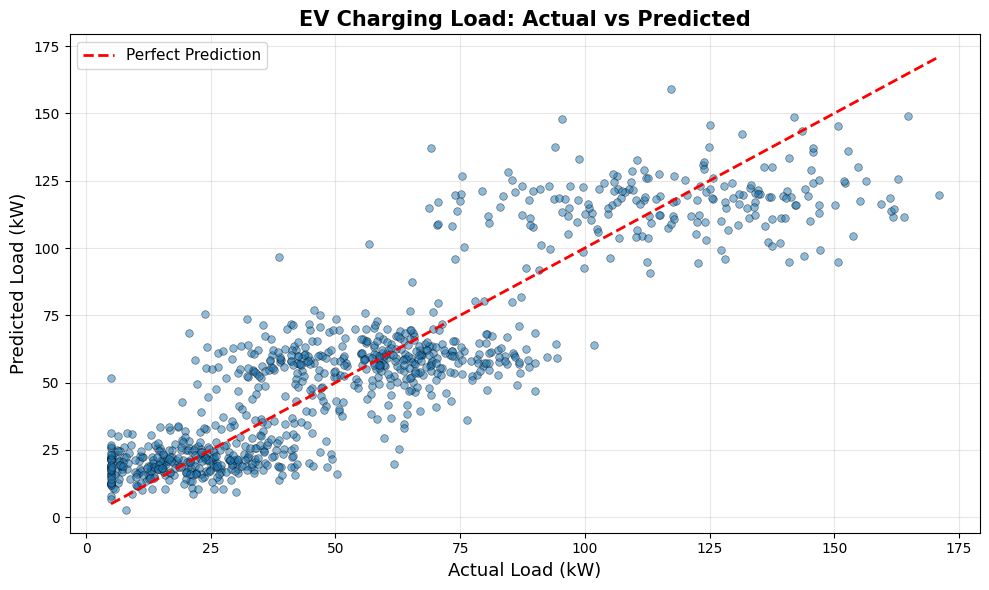

In [30]:
# Convert predictions to Pandas for visualization
predictions_pd = predictions_test.select("label", "prediction").toPandas()

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(predictions_pd['label'], predictions_pd['prediction'],
            alpha=0.5, s=30, edgecolors='k', linewidth=0.5)
plt.plot([predictions_pd['label'].min(), predictions_pd['label'].max()],
         [predictions_pd['label'].min(), predictions_pd['label'].max()],
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Load (kW)', fontsize=13)
plt.ylabel('Predicted Load (kW)', fontsize=13)
plt.title('EV Charging Load: Actual vs Predicted', fontsize=15, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



Feature Importance Ranking:
               feature  importance
             peak_hour    0.380319
              hour_cos    0.125846
           temperature    0.095162
     electricity_price    0.091915
num_available_chargers    0.074221
              hour_sin    0.071919
           day_of_week    0.049926
           hour_of_day    0.032956
             month_sin    0.032054
                 month    0.018747
             month_cos    0.018446
            is_holiday    0.004837
            is_weekend    0.002453
          temp_squared    0.001199


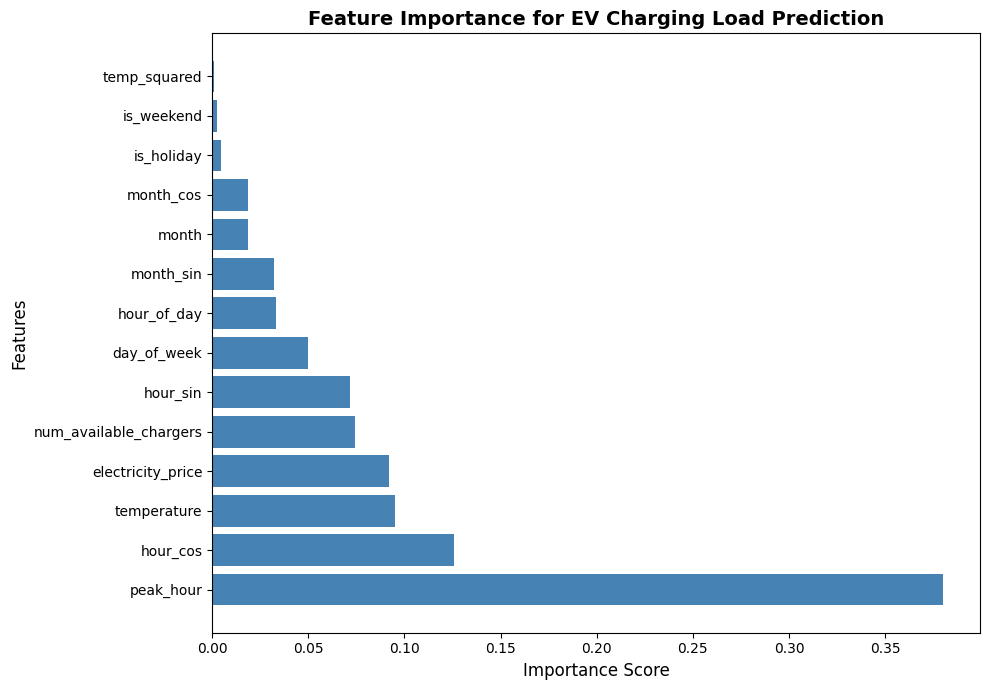

In [31]:
# Get feature importance from the trained model
feature_importance = gbt_model.featureImportances.toArray()
feature_names = feature_cols

# Create DataFrame for feature importance
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\nFeature Importance Ranking:")
print(importance_df.to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(10, 7))
plt.barh(importance_df['feature'], importance_df['importance'], color='steelblue')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Importance for EV Charging Load Prediction',
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [33]:
# Save the trained model
model_path = "/content/ev_charging_load_model"
gbt_model.write().overwrite().save(model_path)
print(f"✅ Model saved to: {model_path}")

# Print summary
print("\n" + "="*70)
print("PROJECT COMPLETED SUCCESSFULLY!")
print("="*70)
print(f"\nDataset: 5000 records of EV charging station data")
print(f"Model: Gradient Boosted Trees Regressor")
print(f"Performance: R² = {test_r2:.4f}, RMSE = {test_rmse:.2f} kW")
print("\nKey Features: hour_of_day, temperature, peak_hour, electricity_price")
print("="*70)


✅ Model saved to: /content/ev_charging_load_model

PROJECT COMPLETED SUCCESSFULLY!

Dataset: 5000 records of EV charging station data
Model: Gradient Boosted Trees Regressor
Performance: R² = 0.7997, RMSE = 17.61 kW

Key Features: hour_of_day, temperature, peak_hour, electricity_price


In [34]:
spark.stop()
print("\n✅ Spark session stopped. All tasks completed!")



✅ Spark session stopped. All tasks completed!
